<figure>
  <IMG SRC="https://raw.githubusercontent.com/fmeer/public-files/main/TUlogo.png" WIDTH=200 ALIGN="right">
</figure>

# Coding the Matrix Method in Python - Notebook 3.2
    
#### This notebook is an extension of Notebook 3.1 with the inclusion of a cell which will allow you to obtain the response in the time domain by using the Fourier Transform. Additionally, we enriched the local dynamic stiffness matrices with spring-dashpot attachments at the edges. Please study this notebook carefully and try to think of examples to check your understanding of the material.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## The Node class
The purpose of this class is to store node information and keep track of the total number of DOFs of the problem. Note the automatic bookkeeping we introduce in `__init__`. This simple but efficient way of keeping track of which DOFs belong to which nodes will make life much easier when we need to assemble matrices from multiple elements. **The code below does not need any modification**.

In [2]:
class Node:
    ndof = 0
    nn   = 0
    
    def clear():
        Node.ndof = 0
        Node.nn = 0
        
    def __init__ (self, x, y):  
        self.x     = x
        self.y     = y
        self.p     = np.zeros(3, dtype=complex)

        self.dofs  = [Node.ndof, Node.ndof+1, Node.ndof+2]

        Node.ndof += 3
        Node.nn   += 1

    def add_load (self, p):  
        self.p += p

## The Element class
This class keeps track of each element in the model, including:
- Cross-section properties
- Element orientation (for coordinate system transformations)
- Which Nodes make up each element, and in turn (with help of the Node class) which DOFs belong to each element

Apart from bookkeeping element data, the other main task of this class is to provide the element stiffness matrix in the global coordinate system (for subsequent assembly) and postprocess element-level fields.

Here the class describes an element combining extension and Euler-Bernoulli bending. A similar (or inherited) class could also be implemented for different element types (*e.g.* shear beam, Timoshenko beam, cable elements, etc). Here we also keep it simple by assuming elements are all arranged in a 2D plane.

#### Check in the element class below the additions of the spring-dashpot attachments at the edges of each element. 

In [3]:
class Element:
    ne = 0

    def clear():
        Element.ne = 0
        
    def __init__ (self, nodes):
        self.nodes = nodes

        self.L = np.sqrt((nodes[1].x - nodes[0].x)**2.0 + (nodes[1].y - nodes[0].y)**2.0)

        dx = nodes[1].x - nodes[0].x
        dy = nodes[1].y - nodes[0].y

        self.cos = dx / self.L
        self.sin = dy / self.L

        R = np.zeros ((6,6))

        R[0,0] = R[1,1] = R[3,3] = R[4,4] = self.cos
        R[0,1] = R[3,4] = -self.sin
        R[1,0] = R[4,3] =  self.sin
        R[2,2] = R[5,5] = 1.0
        
        self.R  = R
        self.Rt = np.transpose(R)

        Element.ne += 1

    def set_section (self, props):
        
        if 'EA' in props:
            self.EA = props['EA']
        else:
            self.EA = 1.e20
            
        if 'ksi' in props: # MODIFIED
            self.ksi = props['ksi'] # MODIFIED
        else: # MODIFIED
            self.ksi = 0.01  # MODIFIED
            
        if 'rhoA' in props:  # MODIFIED
            self.rhoA = props['rhoA']  # MODIFIED
        else:  # MODIFIED
            self.rhoA = 1.e20  # MODIFIED
            
        if 'EI' in props:
            self.EI = props['EI']
        else:
            self.EI = 1.e20
            
        if 'omega' in props:  # MODIFIED
            self.omega = props['omega']  # MODIFIED
        else:   # MODIFIED
            self.omega = 1.e20  # MODIFIED
        
        if 'k_1_r' in props:  # MODIFIED
            self.k_1_r = props['k_1_r']  # MODIFIED
        else:   # MODIFIED
            self.k_1_r = 1.e20  # MODIFIED
            
        if 'k_2_r' in props:  # MODIFIED
            self.k_2_r = props['k_2_r']  # MODIFIED
        else:   # MODIFIED
            self.k_2_r = 1.e20  # MODIFIED
            
        if 'c_1_r' in props:  # MODIFIED
            self.c_1_r = props['c_1_r']  # MODIFIED
        else:   # MODIFIED
            self.c_1_r = 1.e20  # MODIFIED
            
        if 'c_2_r' in props:  # MODIFIED
            self.c_2_r = props['c_2_r']  # MODIFIED
        else:   # MODIFIED
            self.c_2_r = 1.e20  # MODIFIED
        
        if 'k_1_b' in props:  # MODIFIED
            self.k_1_b = props['k_1_b']  # MODIFIED
        else:   # MODIFIED
            self.k_1_b = 1.e20  # MODIFIED
            
        if 'k_2_b' in props:  # MODIFIED
            self.k_2_b = props['k_2_b']  # MODIFIED
        else:   # MODIFIED
            self.k_2_b = 1.e20  # MODIFIED
            
        if 'c_1_b' in props:  # MODIFIED
            self.c_1_b = props['c_1_b']  # MODIFIED
        else:   # MODIFIED
            self.c_1_b = 1.e20  # MODIFIED
            
        if 'c_2_b' in props:  # MODIFIED
            self.c_2_b = props['c_2_b']  # MODIFIED
        else:   # MODIFIED
            self.c_2_b = 1.e20  # MODIFIED
            

    def global_dofs  (self):
        return np.hstack ((self.nodes[0].dofs, self.nodes[1].dofs))

    def stiffness ( self ):
        
        k = np.zeros ((6, 6), dtype=complex) # MODIFIED
        
        ksi = self.ksi # MODIFIED
        EA = self.EA * (1 + 2j * ksi) # MODIFIED
        rhoA = self.rhoA  # MODIFIED 
        EI = self.EI * (1 + 2j * ksi) # MODIFIED
        L = self.L
        omega = self.omega  # MODIFIED
        c_r = (EA/rhoA) ** 0.5  # MODIFIED
        beta_r = omega / c_r  # MODIFIED
        beta_b = (omega**2 * rhoA / EI) ** 0.25  # MODIFIED
        k_1_r = self.k_1_r # MODIFIED
        k_2_r = self.k_2_r # MODIFIED
        c_1_r = self.c_1_r # MODIFIED
        c_2_r = self.c_2_r # MODIFIED
        k_1_b = self.k_1_b # MODIFIED
        k_2_b = self.k_2_b # MODIFIED
        c_1_b = self.c_1_b # MODIFIED
        c_2_b = self.c_2_b # MODIFIED

        # Extension contribution

        k[0,0] = EA * beta_r * np.cos(beta_r * L) / np.sin(beta_r * L) + k_1_r + 1j * omega * c_1_r   # MODIFIED
        k[3,3] = EA * beta_r * np.cos(beta_r * L) / np.sin(beta_r * L) + k_2_r + 1j * omega * c_2_r  # MODIFIED
        k[3,0] = - EA * beta_r / np.sin(beta_r * L) # MODIFIED
        k[0,3] = - EA * beta_r / np.sin(beta_r * L) # MODIFIED

        # Bending contribution
        
        K_beam = np.array([[-EI * beta_b ** 3 * (np.cosh(beta_b * L) * np.sin(beta_b * L) + np.sinh(beta_b * L) * np.cos(beta_b * L)) / (np.cosh(beta_b * L) * np.cos(beta_b * L) - 1),EI * np.sinh(beta_b * L) * np.sin(beta_b * L) * beta_b ** 2 / (np.cosh(beta_b * L) * np.cos(beta_b * L) - 1),EI * beta_b ** 3 * (np.sinh(beta_b * L) + np.sin(beta_b * L)) / (np.cosh(beta_b * L) * np.cos(beta_b * L) - 1),EI * beta_b ** 2 * (np.cosh(beta_b * L) - np.cos(beta_b * L)) / (np.cosh(beta_b * L) * np.cos(beta_b * L) - 1)],[EI * np.sinh(beta_b * L) * np.sin(beta_b * L) * beta_b ** 2 / (np.cosh(beta_b * L) * np.cos(beta_b * L) - 1),EI * beta_b * (-np.cosh(beta_b * L) * np.sin(beta_b * L) + np.sinh(beta_b * L) * np.cos(beta_b * L)) / (np.cosh(beta_b * L) * np.cos(beta_b * L) - 1),EI * beta_b ** 2 * (-np.cosh(beta_b * L) + np.cos(beta_b * L)) / (np.cosh(beta_b * L) * np.cos(beta_b * L) - 1),EI * beta_b * (-np.sinh(beta_b * L) + np.sin(beta_b * L)) / (np.cosh(beta_b * L) * np.cos(beta_b * L) - 1)],[EI * beta_b ** 3 * (np.sinh(beta_b * L) + np.sin(beta_b * L)) / (np.cosh(beta_b * L) * np.cos(beta_b * L) - 1),EI * beta_b ** 2 * (-np.cosh(beta_b * L) + np.cos(beta_b * L)) / (np.cosh(beta_b * L) * np.cos(beta_b * L) - 1),-EI * beta_b ** 3 * (np.cosh(beta_b * L) * np.sin(beta_b * L) + np.sinh(beta_b * L) * np.cos(beta_b * L)) / (np.cosh(beta_b * L) * np.cos(beta_b * L) - 1),-EI * np.sinh(beta_b * L) * np.sin(beta_b * L) * beta_b ** 2 / (np.cosh(beta_b * L) * np.cos(beta_b * L) - 1)],[EI * beta_b ** 2 * (np.cosh(beta_b * L) - np.cos(beta_b * L)) / (np.cosh(beta_b * L) * np.cos(beta_b * L) - 1),EI * beta_b * (-np.sinh(beta_b * L) + np.sin(beta_b * L)) / (np.cosh(beta_b * L) * np.cos(beta_b * L) - 1),-EI * np.sinh(beta_b * L) * np.sin(beta_b * L) * beta_b ** 2 / (np.cosh(beta_b * L) * np.cos(beta_b * L) - 1),EI * beta_b * (-np.cosh(beta_b * L) * np.sin(beta_b * L) + np.sinh(beta_b * L) * np.cos(beta_b * L)) / (np.cosh(beta_b * L) * np.cos(beta_b * L) - 1)]])

        k[1,1] = K_beam[0,0] + (k_1_b + 1j*omega*c_1_b)
        k[1,2] = K_beam[0,1]
        k[1,4] = K_beam[0,2]
        k[1,5] = K_beam[0,3]
        k[2,1] = K_beam[1,0]
        k[2,2] = K_beam[1,1]
        k[2,4] = K_beam[1,2]
        k[2,5] = K_beam[1,3]
        k[4,1] = K_beam[2,0]
        k[4,2] = K_beam[2,1]
        k[4,4] = K_beam[2,2] + (k_2_b + 1j*omega*c_2_b)
        k[4,5] = K_beam[2,3]
        k[5,1] = K_beam[3,0]
        k[5,2] = K_beam[3,1]
        k[5,4] = K_beam[3,2]
        k[5,5] = K_beam[3,3]

        return np.matmul ( np.matmul ( self.Rt, k ), self.R )
    
    

## The Constrainer class

This small class keeps track of which DOFs have prescribed displacements and takes care of applying these constraints to the global $\mathbf{K}$ and $\mathbf{f}$. For now we keep it simple and assume all constraints fix the DOF values to zero. Next week we will deal with constraints to non-zero prescribed values. For the first two examples you can use this class as it is. For the third assignment, a short new function should be implemented (see below).

In [4]:
class Constrainer:
    def __init__ (self):
        self.dofs = []

    def fix_dof (self, node, dof):
        self.dofs.append (node.dofs[dof])
 
    def fix_node (self, node):
        for dof in node.dofs:
            self.dofs.append (dof)       

    def constrain (self, k, f):
        kc = np.copy (k)
        fc = np.copy (f)
        
        for dof in self.dofs:
            fc[dof] = 0.0
            kc[:,dof] = kc[dof,:] = 0.0
            kc[dof,dof]           = 1.0

        return kc, fc

## Sanity check #1: Bar in extension with elastic support instead of fixed edge...

Having made our implementations, we now check them with two simple examples that serve as sanity checks. The first is a simple bar undergoing extension. 

#### Task: Please try to complicate one of the boundaries with an elastic or viscoelastic attachment at the end. Does the implementation of the spring-dashpot attachment in the element class work propely?

<figure>
  <IMG SRC="https://raw.githubusercontent.com/ibcmrocha/public/main/ssbeam.png" WIDTH=200 ALIGN="center">
</figure>

Use the code blocks below to set up and solve this problem using the classes above. The steps to follow are outlined below and short explanations/hints are given.

### Parameters

We define the parameters here for convenience. We also use the `clear` functions to restart the node, element and DOF counters. Make sure this is done whenever you start solving a new problem.

In [5]:
EA = 7e6
EI = 1.5 * 7e06 # MODIFIED
rhoA = 1e03  # MODIFIED
F  = 1e06 + 0j # MODIFIED: This is just to illustrate the use of FFT. This force does not reflect a force in the time domain!
q_r = 0*1e06 # MODIFIED
q_b = 0 # MODIFIED
L  = 1
omega = 100  # MODIFIED
ksi = 0.01 # MODIFIED
beta_r = omega / (EA*(1+2j*ksi)/rhoA) ** 0.5 # MODIFIED
beta_b = (omega**2 * rhoA / (EI*(1+2j*ksi))) ** 0.25 # MODIFIED
k_1_r, k_2_r, c_1_r, c_2_r, k_1_b, k_2_b, c_1_b, c_2_b = 0, 0, 0, 0, 0, 0, 0, 0

Node.clear()
Element.clear()

### Create nodes

Create two nodes here. You can store them on a `list` or simply create them as two separate objects (*e.g.* `node1` and `node2`). 

**TIP**: Take a look at which arguments the `__init__` function of the `Node` class receives!

In [6]:
node1 = Node (0,0)
node2 = Node (L,0)

### Create element

Here we only have a single element, so there is no need to store it in a `list` yet. You are also going to need a `dict` defining the cross-section of the element.

**TIP**: See what `__init__` of the `Element` class expects. Also check the `set_section` function.

In [7]:
elem = Element ( [node1, node2] )

section = {}
section['EA'] = EA
section['EI'] = EI
section['ksi'] = ksi  # MODIFIED
section['rhoA'] = rhoA  # MODIFIED
section['omega'] = omega  # MODIFIED
section['k_1_r'] = k_1_r
section['k_2_r'] = k_2_r
section['c_1_r'] = c_1_r
section['c_2_r'] = c_2_r
section['k_1_b'] = k_1_b
section['k_2_b'] = k_2_b
section['c_1_b'] = c_1_b
section['c_2_b'] = c_2_b

elem.set_section (section)

### Set boundary conditions

We create an instance of the `Constrainer` class to deal with prescribed displacements. Take a look at its functions and inform it Node 1 is fully fixed.

**TIP**: You also need to pass the load $F$ on to Node 2. Check the member functions of `Node` to infer how that should be done.

In [8]:
con = Constrainer()

con.fix_node (node1)
node2.add_load ([F,0,0])

### Assemble the system of equations

Since we only have one element, there is no real assembly to be performed other than getting the stiffness matrix of the single element and storing the load at Node 2 in the correct positions of $\mathbf{f}$. To avoid confusion, we do this part for you. Just take care to change the name of the element or of Node 2 in case you used something different.

In [9]:
global_k = elem.stiffness()
global_f = np.zeros (6, dtype=complex)

global_f[3:6] = node2.p 
#print(global_k)
print(global_f)

[      0.+0.j       0.+0.j       0.+0.j 1000000.+0.j       0.+0.j
       0.+0.j]


### Constrain the problem and solve for nodal displacements

Try to solve for $u$ as it is written in this block. You will notice that `global_k` is singular. Why is that the case? 

**TIP**: Use the `Constrainer` class to fix that! It already knows three of our DOFs are fixed to zero, you should just let it make the necessary changes to $\mathbf{K}$ and $\mathbf{f}$.

In [10]:
Kc, Fc = con.constrain ( global_k, global_f )
u = np.matmul ( np.linalg.inv(Kc), Fc )
print(u)

[0.        +0.j         0.        +0.j         0.        +0.j
 0.30250885-0.01361971j 0.        +0.j         0.        +0.j        ]


### Compare with the solution you know

Finally, compare the displacement at the end of the bar with the one coming from the ODE solution. Note that $\mathbf{u}$ has six entries. Which one is the entry that matters to us here?

**TIP**: Remember the DOF ordering we assume ($\left[u\,\,w\,\,\varphi\right]$) and the order we use to create our nodes (check `__init__` of the `Node` class one more time!)

In [11]:
print('ODE solution (0.30250884529318846290, - 0.013619705006987083063 j)','Matrix method solution',u[3]) 
# CHECK MAPLE FILE FOR ANALYTICAL DERIVATION

ODE solution (0.30250884529318846290, - 0.013619705006987083063 j) Matrix method solution (0.30250884529318856-0.013619705006987096j)


### Task: Please try to upload a time signal of your choice and apply the FFT method. What changes do you need to implement in the code to be able to find the response in the time domain?

### Obtain the response in time domain

The response can be retrieved in the time domain by means of the FFT algorithm as follows:

Text(0,0.5,'u [m]')

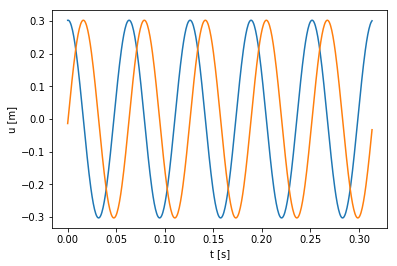

In [12]:
t = np.arange(0, 5*2*np.pi/omega, 2*np.pi/omega/100) # A time series with 5 periods duration and time step equal to 1% of the period (the period of the force above)

freqs = np.fft.fftfreq(len(t), t[1]) # Frequencies corresponding to an FFT of a signal recorded at a time series t.

u_fd = np.zeros((len(u),len(freqs)), dtype=complex) # Initializing frequency domain signal 

u_fd[:, 5] = u # Assigning to the 6-th column the displacement vector at frequency domain

u_td = np.fft.ifft(u_fd) * len(t) # Recorded signal in time domain. 

plt.figure()
plt.plot(t, u_td[3].real)
plt.plot(t, u_td[3].imag)
plt.xlabel('t [s]')
plt.ylabel('u [m]')
#plt.close()